## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Modules import Muon, Positron, func

from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

## Aligned muons decaying in uniform field
Change the p.phase line for aligned or random phase muons

Generates N particles and sorts by lifetime

In [16]:
N = 10000
particles = [Muon() for _ in range(N)]
for p in particles:
    p.revs = p.get_decay_orientation(0.001)  # 0.001 Tesla - returns values {0, 2pi}
    #p.phase = np.random.uniform(0, 2*np.pi)
    p.phase = 0
    p.decay_angle = np.sin((p.revs + p.phase) % (2*np.pi))
    p.polarisation = p.get_spin_polarisation(0.001, np.pi/2)
particles.sort(key=lambda x: x.lifetime)

#print("Frequency of oscillation is: {}".format(freq))

#### Plot of angle against decay time
Decay angle is a value [0, 2pi] for muons depending on larmor frequency and lifetime.

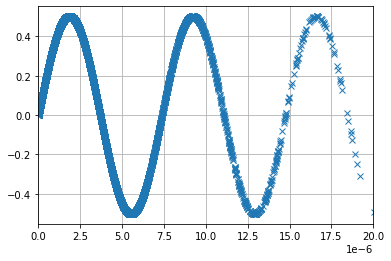

In [18]:
plt.figure()
life = np.zeros(len(particles))
decay_angle = np.zeros(len(particles))

for i, particle in enumerate(particles):
    life[i] = particle.lifetime
    decay_angle[i] = particle.decay_angle * p.polarisation
    
plt.plot(life, decay_angle, "x")
plt.xlim(0, 20e-6)
plt.grid()
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.show()

#### Histogram of decay times

In [14]:
def expon(x, A, k):
    return A*np.exp(x*k)

<Figure size 432x288 with 0 Axes>

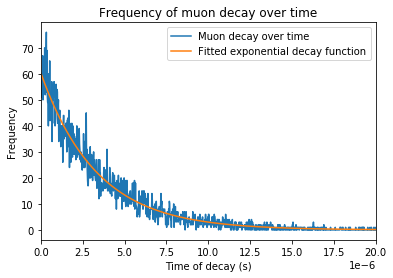

In [15]:
lifetimes = np.array([i.lifetime for i in particles])
bins = np.linspace(0, 20e-6, 1000)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])


frequency, bins, _ = plt.hist(lifetimes, bins=bins, range=(0, 20e-6))
plt.clf()
popt, cpov = curve_fit(expon, binscenters, frequency)

plt.figure()
plt.plot(binscenters, frequency, label="Muon decay over time")
plt.plot(binscenters, expon(binscenters, *popt), label="Fitted exponential decay function")
plt.xlabel("Time of decay (s)")
plt.ylabel("Frequency")
plt.xlim(0, 20e-6)
plt.legend(loc="best")
plt.title("Frequency of muon decay over time")
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.show()

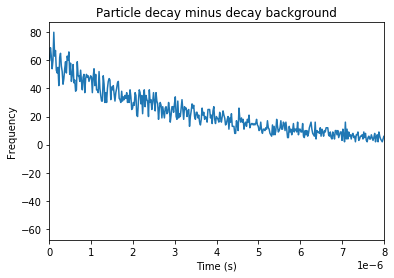

In [6]:
oscillation = [x-y for x, y in zip(frequency, expon(frequency, *popt))]
plt.figure()
plt.plot(binscenters, oscillation)
plt.xlim(0, 8e-6)
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.xlabel("Time (s)")
plt.ylabel("Frequency")
plt.title("Particle decay minus decay background")
plt.show()

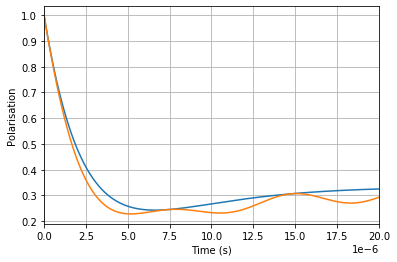

In [7]:
omega = func.larmor_freq(0.001)
ang_pre = func.angular_precession(binscenters, omega, np.pi/1.1)
precession_with_decay = [x*y for x, y in zip(func.polarisation(binscenters), ang_pre)]

plt.figure()
plt.plot(binscenters, func.polarisation(binscenters), label="Kubo-Toyabe")
plt.plot(binscenters, precession_with_decay, label="Polarisation times angular precession")
plt.xlim(0, 20e-6)
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.xlabel("Time (s)")
plt.ylabel("Polarisation")
plt.title("")
plt.grid()
plt.show()